In [4]:
!pip install transformers
!pip install langdetect
#!pip install EmailParser

import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re

from transformers import *
from langdetect import detect
from langdetect import DetectorFactory

nlp = spacy.blank("de")


In [6]:
def preprocessFull(text):
  words = []
  try:
      # tokenize in sentences
      sentences = nltk.sent_tokenize(text, language='german')
      sentences_tok = [nltk.word_tokenize(sent, language='german') for sent in sentences]
      for sent in sentences_tok:
          tags = tagger.tag_sent(sent)
          words_from_sent = [lemma for (word, lemma, pos) in tags]
          words.extend(words_from_sent)    
  except TypeError:
      pass
  except KeyError:
      print("KeyError")
      pass
  return " ".join(words)

def grouping(tuple_list, threshold, new_label):
  grouped_value = 0
  new_list = []
  for tup in tuple_list:
    if tup[1] < threshold:
      grouped_value += tup[1]
    else:
      new_list.append(tup)
  new_list.append((new_label, grouped_value))
  return new_list

# def df_relabel(dataframe, column, label_group):
#   for index in range(len(dataframe)):
#     if not dataframe.iloc[index][column] in (label_group):
#       dataframe.iloc[index][column] = "Others"

def df_relabel(dataframe, column, label_group):
   for index in range(len(dataframe)):
    if not dataframe.iloc[index][column] in (label_group):
      dataframe.iloc[index, dataframe.columns.get_loc(column)] = "Others"

      # dataframe.loc[index][column] = "Others"




def AvgMedianLen(x):
  df = {}
  df['mean_character_count'] = x['MailTextBody'].str.len().mean()
  df['mean_word_count'] = x['MailTextBody'].str.split().str.len().mean()
  return pd.Series(df, index=['mean_character_count', 'mean_word_count'])

def identify_language(document):
    return detect(document.lower())


# Plot label distribution of the data.
def plot_label_distribution(df, label_name, threshold=False):
  """Input: Dataframe, threshold for filtering label frequency.Output: Plotting of label distribution of dataset.""" 
  label_count_dic = df[label_name].value_counts().to_dict()
  label_list = [] # going to be x-axis
  label_freq_list = [] # going to be y-axis
  
  for label, freq in zip(label_count_dic.keys(), label_count_dic.values()):
    # If threshold applies, filter values above threshold.
    if threshold != False: 
      if freq < threshold:
        label_list.append((label))
        label_freq_list.append((freq))
    else:
        label_list.append(label)
        label_freq_list.append((freq))
  # Plotting the distribution.
  plt.figure(figsize=(20,10))
  plt.xticks(rotation="vertical", fontsize=10)
  plt.title("Distribution of All Labels") if threshold == False else plt.title("Label Distribution with Thresholded Labels Frequencies")
  plt.bar(label_list, label_freq_list)
  return plt.show()


In [9]:
train = pd.read_csv("/datalab/data/train.csv", sep=";")
test = pd.read_csv("/datalab/data/test_reduced.csv", sep=";")

train.head()

,Unnamed: 0,Id,Impact,Urgency,IncidentType,ServiceProcessed,MailSubject,MailTextBody,ManualGroups
0,3554,INC000010587669,4-Minor/Localized,2-High,Failure,EDA_S_BA_2FA,smart card blockiert MD5:2225e4a30a5b7e592ba34...,lieber helpdesk sie haben mir den computer fr...,NaN
1,3553,INC000010585556,4-Minor/Localized,4-Low,Service Request,EDA_S_Order Management,FW: Webcam MD5:f757a42a9bdb1dfd9c8427e588586ca8,liebe kolleginnen und kollegen ich möchte für...,NaN
2,3552,INC000010585519,4-Minor/Localized,4-Low,Failure,EDA_S_Peripheriegeräte,FW: IT Support heute Nachmittag MD5:bc594d6bfd...,liebe kolleginnen und kollegen es handelt sic...,NaN
3,3549,INC000010582950,4-Minor/Localized,4-Low,Service Request,EDA_S_Benutzerunterstützung,Botschaft Warschau - Administratoren-Zugang f...,"sehr geehrte damen und herren, die botschaft ...",Benutzeranleitungen_Telefonie
4,3548,INC000010582919,4-Minor/Localized,4-Low,Service Request,EDA_S_Order Management,FW: Commande d'un écran MD5:c2b8cb3281fed4e2d4...,liebe kolleginnen und kollegen ich möchte für...,NaN


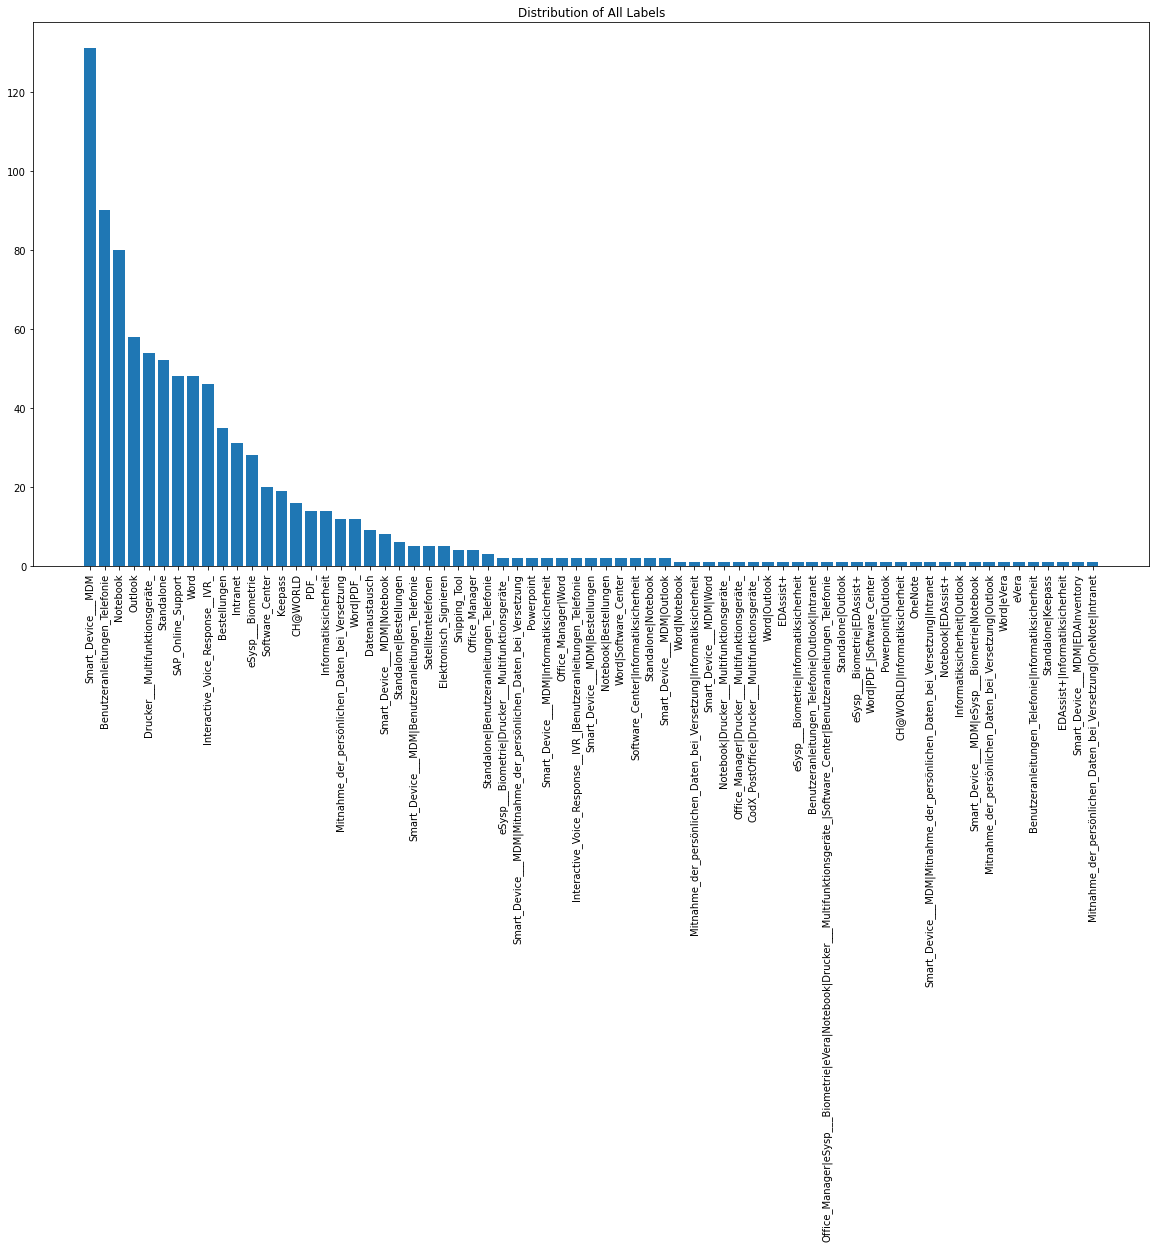

In [10]:
plot_label_distribution(train, "ManualGroups", threshold=False)

### Nan Values in Manual Groups

In [11]:
train["ManualGroups"].isna().sum()

1935

##### Turns out we have substantial amount of nan values in manual groups. We are going to label them as "Unknown"

In [12]:
train.fillna("Unknown", inplace=True)

In [13]:
train["ManualGroups"].isna().sum()

0

###### Now we filled the empty tags.

#### Decide if we would merge low number of observations all together.

In [14]:
train["WholeMail"] = train["MailSubject"] + " " + train["MailTextBody"]

In [15]:
train.head()

,Unnamed: 0,Id,Impact,Urgency,IncidentType,ServiceProcessed,MailSubject,MailTextBody,ManualGroups,WholeMail
0,3554,INC000010587669,4-Minor/Localized,2-High,Failure,EDA_S_BA_2FA,smart card blockiert MD5:2225e4a30a5b7e592ba34...,lieber helpdesk sie haben mir den computer fr...,Unknown,smart card blockiert MD5:2225e4a30a5b7e592ba34...
1,3553,INC000010585556,4-Minor/Localized,4-Low,Service Request,EDA_S_Order Management,FW: Webcam MD5:f757a42a9bdb1dfd9c8427e588586ca8,liebe kolleginnen und kollegen ich möchte für...,Unknown,FW: Webcam MD5:f757a42a9bdb1dfd9c8427e588586ca...
2,3552,INC000010585519,4-Minor/Localized,4-Low,Failure,EDA_S_Peripheriegeräte,FW: IT Support heute Nachmittag MD5:bc594d6bfd...,liebe kolleginnen und kollegen es handelt sic...,Unknown,FW: IT Support heute Nachmittag MD5:bc594d6bfd...
3,3549,INC000010582950,4-Minor/Localized,4-Low,Service Request,EDA_S_Benutzerunterstützung,Botschaft Warschau - Administratoren-Zugang f...,"sehr geehrte damen und herren, die botschaft ...",Benutzeranleitungen_Telefonie,Botschaft Warschau - Administratoren-Zugang f...
4,3548,INC000010582919,4-Minor/Localized,4-Low,Service Request,EDA_S_Order Management,FW: Commande d'un écran MD5:c2b8cb3281fed4e2d4...,liebe kolleginnen und kollegen ich möchte für...,Unknown,FW: Commande d'un écran MD5:c2b8cb3281fed4e2d4...


In [20]:
# Main Cleaning

import re

nlp= spacy.blank("de")
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
new_text ={"WholeMail":[], "ManualGroups":[]}
s= 0

labels = {}
inv_labels={}
c=0

for index in range(len(train)):
  email = str(train.iloc[index]["WholeMail"])
  phrase = []
  for word in str(email).split():

    if ("MD5" not in word) and ("www" not in word) and ("FW:" not in word) and ("[cid:i" not in word) :
      phrase.append(word.lower())

  email = " ".join(phrase)
  email = re.sub(pattern, "", email)
  tokenized_sentence = " ".join([token.text for token in nlp(email)])
  if len(tokenized_sentence)>10000:
    print(len(tokenized_sentence))
    continue
  if identify_language(tokenized_sentence ) == "de":
    new_text["WholeMail"].append(tokenized_sentence )
    new_text["ManualGroups"].append(str(train.iloc[index]["ManualGroups"]))

    if str(train.iloc[index]["ManualGroups"]) not in labels:

      labels[str(train.iloc[index]["ManualGroups"])]=c

      inv_labels[str(c)] = str(train.iloc[index]["ManualGroups"])

      c+=1

    if str(train.iloc[index]["ManualGroups"]) != "Unknown":

        new_text["WholeMail"].append(tokenized_sentence )
        new_text["ManualGroups"].append(str(train.iloc[index]["ManualGroups"]))

        new_text["WholeMail"].append(tokenized_sentence )
        new_text["ManualGroups"].append(str(train.iloc[index]["ManualGroups"]))


        new_text["WholeMail"].append(tokenized_sentence )
        new_text["ManualGroups"].append(str(train.iloc[index]["ManualGroups"]))






      



print(len(new_text["ManualGroups"]), len(new_text["ManualGroups"]))




31703
14837
24084
25680
23994
10495
12912
5240 5240


In [ ]:
new_text["WholeMail"][2]

'it support heute nachmittag liebe kolleginnen und kollegen es handelt sich um eine sitzung der deza-direktion heute um 16.30 uhr im sitzungszimmer 0 1 2 3 . darf ich sie gem. untenstehendem mail bitten , dass jemand vor ort sein kann ? besten dank und bei fragen stehe ich zur verfügung . freundliche grüsse rahel fitze direktionsassistentin eidgenössisches departement für auswärtige angelegenheiten eda direktion für entwicklung und zusammenarbeit deza freiburgstrasse 0 1 2 3 , ch-0 1 2 3 bern , schweiz tel : +0 1 2 3 fax . +41 website : from : sent : thursday , october 29 , 2020 11:29 am to : subject : it support heute nachmittag liebe rahel die dr hat ein neues videosystem im a-0 1 2 3 . ich habe eben versucht , es in gang zu bringen , hat aber nicht geklappt . könnest du mir für heute nachmittag einen support organisieren ? 16.30 vor ort wäre ideal . liebe grüsse'

In [ ]:
train = pd.DataFrame.from_dict(new_text)
train.head()

,WholeMail,ManualGroups
0,smart card blockiert lieber helpdesk sie haben...,Unknown
1,webcam liebe kolleginnen und kollegen ich möch...,Unknown
2,it support heute nachmittag liebe kolleginnen ...,Unknown
3,botschaft warschau - administratoren-zugang fü...,Benutzeranleitungen_Telefonie
4,commande d'un écran liebe kolleginnen und koll...,Unknown


In [21]:
train_data = []

for i in range(len(new_text["ManualGroups"])):

    one_hot = [0] * len(labels)

    one_hot[labels[new_text["ManualGroups"][i]]]= 1

    sample= [new_text["WholeMail"][i],one_hot]

    train_data.append(sample)


In [22]:
train_df = pd.DataFrame(train_data, columns=['text', 'labels'])

In [23]:
train_df.head()

,text,labels
0,smart card blockiert lieber helpdesk sie haben...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,webcam liebe kolleginnen und kollegen ich möch...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,it support heute nachmittag liebe kolleginnen ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,botschaft warschau - administratoren-zugang fü...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,botschaft warschau - administratoren-zugang fü...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
train_obs[66]

'erneute probleme mit secure mail ( mdm ) nach mxm 14 upgrade guten tag im namen von frau gabriella spirli sgq möchte ich bei ihnen folgendes problem melden : vor zwei wochen hat frau spirli das ios 14 update auf ihrem iphone durchgeführt . über das wochenende hatte sie dann keinen zugriff mehr auf ihre emails . nach kontaktaufnahme mit dem helpdesk ( montag , 28.09.20 ) hat sie die secure mail app gelöscht und wieder installiert . danach hat der mailzugriff wieder einwandfrei funktioniert . letzten freitagnachmittag ist wieder dasselbe problem aufgetreten . über das vergangene wochenende hatte frau spirli wieder keinen zugriff auf ihre mails . heute morgen hat die synchronisation dann aber wieder geklappt . nun zeigt die app aber permanent an , dass sich noch 1 ungelesene mail im posteingang befindet , obwohl frau spirli entweder gar keine oder mehr als 1 ungelesene mail in ihrem postfach hat . frau spirli hat heute nachmittag ihr iphone ganz ausgeschaltet , aber die app zeigt nach wi

NameError: ignored

51

{'0000000000000000000000000000000000000000000000000000000000000001': 'eVera',
 '0000000000000000000000000000000000000000000000000000000000000010': 'eSysp___Biometrie|Informatiksicherheit',
 '0000000000000000000000000000000000000000000000000000000000000100': 'eSysp___Biometrie|EDAssist+',
 '0000000000000000000000000000000000000000000000000000000000001000': 'eSysp___Biometrie|Drucker___Multifunktionsgeräte_',
 '0000000000000000000000000000000000000000000000000000000000010000': 'eSysp___Biometrie',
 '0000000000000000000000000000000000000000000000000000000000100000': 'Word|eVera',
 '0000000000000000000000000000000000000000000000000000000001000000': 'Word|Software_Center',
 '0000000000000000000000000000000000000000000000000000000010000000': 'Word|PDF_|Software_Center',
 '0000000000000000000000000000000000000000000000000000000100000000': 'Word|PDF_',
 '0000000000000000000000000000000000000000000000000000001000000000': 'Word|Outlook',
 '00000000000000000000000000000000000000000000000000000100

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

50

array([['Unknown'],
       ['Unknown'],
       ['Unknown'],
       ...,
       ['Unknown'],
       ['Unknown'],
       ['SAP_Online_Support']], dtype=object)

array(['Benutzeranleitungen_Telefonie',
       'Benutzeranleitungen_Telefonie|Informatiksicherheit',
       'Benutzeranleitungen_Telefonie|Outlook|Intranet', 'Bestellungen',
       'CH@WORLD', 'CH@WORLD|Informatiksicherheit',
       'CodX_PostOffice|Drucker___Multifunktionsgeräte_',
       'Datenaustausch', 'Drucker___Multifunktionsgeräte_', 'EDAssist+',
       'Elektronisch_Signieren', 'Informatiksicherheit',
       'Informatiksicherheit|Outlook', 'Interactive_Voice_Response__IVR_',
       'Interactive_Voice_Response__IVR_|Benutzeranleitungen_Telefonie',
       'Intranet', 'Keepass',
       'Mitnahme_der_persönlichen_Daten_bei_Versetzung',
       'Mitnahme_der_persönlichen_Daten_bei_Versetzung|Informatiksicherheit',
       'Notebook', 'Notebook|Bestellungen',
       'Notebook|Drucker___Multifunktionsgeräte_', 'Office_Manager',
       'Office_Manager|Drucker___Multifunktionsgeräte_',
       'Office_Manager|Word',
       'Office_Manager|eSysp___Biometrie|eVera|Notebook|Drucker___Multifu

In [ ]:
final_labels

NameError: ignored

,text,labels
0,smart card blockiert lieber helpdesk sie haben...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,webcam liebe kolleginnen und kollegen ich möch...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,it support heute nachmittag liebe kolleginnen ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,botschaft warschau - administratoren-zugang fü...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,commande d'un écran liebe kolleginnen und koll...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,richclient photo mit partikel einen schönen gu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
from sklearn.utils import shuffle

In [ ]:
dataset = [[final_data_df.iloc[index]["text"], final_data_df.iloc[index]["labels"]] for index in range(len(final_data_df))]

final_data_df = shuffle(final_data_df)

In [ ]:
trainset, testset = final_data_df[:int(len(final_data_df) * 0.80)], final_data_df[int(len(final_data_df) * 0.80):]

from sklearn.model_selection import train_test_split

In [ ]:
trainset_df = pd.DataFrame(trainset)
testset_df = pd.DataFrame(testset)

In [ ]:
trainset_df

,text,labels
682,internet seite ist seit sperrung internet expl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
368,mxm-portal ohne zertifikat sehr geehrte damen ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1772,zugriffe lms / ch@world guten tag ich habe am ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1590,diensthandy ( iphone ) für sektion hupo guten ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1791,termin in agenda löschen - fehlermeldung guten...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
174,probleme beim anschliessen an den server liebe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1681,e-order asset inventory management mxm guten t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1802,smartcards reserve liebe kolleginnen und kolle...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
692,passdrucker diletta 600i guten morgen bern der...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
!pip install simpletransformers

     |████████████████████████████████| 225kB 12.2MB/s 
     |████████████████████████████████| 7.4MB 43.5MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 317kB 38.5MB/s 
     |████████████████████████████████| 1.8MB 50.8MB/s 
     |████████████████████████████████| 4.5MB 53.0MB/s 
     |████████████████████████████████| 6.9MB 46.6MB/s 
     |████████████████████████████████| 133kB 60.8MB/s 
     |████████████████████████████████| 163kB 62.9MB/s 
     |████████████████████████████████| 112kB 60.2MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 133kB 60.1MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 122kB 60.4MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-c

In [26]:
from multiprocessing import cpu_count

args = {
    "output_dir": "outputs/",
    "cache_dir": "cache_dir/",
    "fp16": True,
    "max_seq_length": 512,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "eval_batch_size": 4,
    "use_multiprocessing":True,
    "num_train_epochs": 10,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    'sliding_window': True,
    "max_grad_norm": 1.0,
    "logging_steps": 50,
    "save_steps": 1000,
    "overwrite_output_dir": True,
    "reprocess_input_data": True,
    "evaluate_during_training": False,
    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
    "use_early_stopping": True,
    "early_stopping_patience": 5,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,
    "manual_seed": None,
    "encoding": None,
    "config": {}
}


In [27]:
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import (
    MultiLabelClassificationModel, MultiLabelClassificationArgs
)
import pandas as pd
import logging



# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('bert', 'bert-base-german-dbmdz-uncased', args=args, num_labels=len(labels))
#TODO: how to assign 4 outputs from this model ????????

#model = ClassificationModel('bert', 'bert-base-german-dbmdz-uncased', num_labels=len(set(translate_dict)), args=args)

Some weights of the model checkpoint at bert-base-german-dbmdz-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassificat

In [ ]:
final_data_df

In [ ]:
# Train the model
model.train_model(train_df, args=args)#, eval_df=testset_df)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(
    final_data_df
)


In [ ]:
print(result, model_outputs)

{'LRAP': 0.792020068235237, 'eval_loss': 0.03156712366689717} [[0.0340271  0.00024343 0.00017953 ... 0.00076723 0.00078869 0.00096226]
 [0.03683472 0.00025725 0.00019562 ... 0.00075245 0.00079775 0.00100803]
 [0.03234863 0.00023413 0.00016999 ... 0.00074673 0.00077915 0.00093651]
 ...
 [0.03283691 0.00024343 0.00018096 ... 0.000741   0.00077915 0.00096226]
 [0.03204346 0.00024915 0.00017405 ... 0.00077915 0.00079775 0.00096607]
 [0.03240967 0.00031257 0.00025725 ... 0.0009737  0.00100803 0.00124931]]


### Preparing the test data for predictions.

In [ ]:
test.head()

,Unnamed: 0,Id,MailSubject,MailTextBody
0,2122,INC000009681999,Traveler 0 1 2 3 austauschen (altes Modell),guten tag wir haben im 5. stock an der bg32 e...
1,202,INC000009004056,Orchestrator läuft nicht,hallo helpdesk orchestrator läuft nicht. d...
2,536,INC000009244944,Ausschalten des Bildschirms eines Laptops,liebe kolleginnen und kollegen mein kolleg...
3,22,INC000008891561,Skype,bitte den neuen mitarbeiter daniel kleis kln i...
4,2249,INC000009702828,Dell Laptop Batterie,liebes helpdesk die batterie meines dell lap...


In [ ]:
test["WholeMail"] = test["MailSubject"] + " " + test["MailTextBody"]

In [ ]:
# Test data cleaning
nlp= spacy.blank("de")
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
test_text ={"WholeMail":[]}

ids = []

s= 0
for index in range(len(test)):
  email = str(test.iloc[index]["WholeMail"])
  phrase = []
  for word in str(email).split():
    
    if ("MD5" not in word) and ("www" not in word) and ("FW:" not in word) and ("[cid:i" not in word) :
      phrase.append(word.lower())

  email = " ".join(phrase)
  email = re.sub(pattern, "", email)
  tokenized_sentence = " ".join([token.text for token in nlp(email)])

  test_text["WholeMail"].append(tokenized_sentence )

  ids.append(str(test.iloc[index]["Id"]))

print(len(test_text["WholeMail"]))



687


In [ ]:
test.head()

,Unnamed: 0,Id,MailSubject,MailTextBody,WholeMail
0,2122,INC000009681999,Traveler 0 1 2 3 austauschen (altes Modell),guten tag wir haben im 5. stock an der bg32 e...,Traveler 0 1 2 3 austauschen (altes Modell) gu...
1,202,INC000009004056,Orchestrator läuft nicht,hallo helpdesk orchestrator läuft nicht. d...,Orchestrator läuft nicht hallo helpdesk or...
2,536,INC000009244944,Ausschalten des Bildschirms eines Laptops,liebe kolleginnen und kollegen mein kolleg...,Ausschalten des Bildschirms eines Laptops lieb...
3,22,INC000008891561,Skype,bitte den neuen mitarbeiter daniel kleis kln i...,Skype bitte den neuen mitarbeiter daniel kleis...
4,2249,INC000009702828,Dell Laptop Batterie,liebes helpdesk die batterie meines dell lap...,Dell Laptop Batterie liebes helpdesk die bat...


In [ ]:
test_data = list(test["WholeMail"].values)
test_data[0]

'Traveler 0 1 2 3 austauschen (altes Modell) guten tag  wir haben im 5. stock an der bg32 einen traveler notebook, welcher wir nicht für die nutzung von präsentationen in unseren sitzungsräumen gebrauchen können, da der hdmi-anschluss nicht passt (altes modell). darf ich sie bitten, diesen laptop mit der serien-nr. 0 1 2 3 zu ersetzen? er befindet sich in meinem büro 0 1 2 3 . admin für diesen traveler ist frau christine schwitter swe.  falls sie noch mehr informationen benötigen, lassen sie es mich wissen. vielen dank!  freundliche grüsse'

In [ ]:

# Make predictions with the model
predictions, raw_outputs = model.predict(test_data)

In [ ]:
predicte

KeyError: ignored

In [ ]:
predicted = []

for i in range(len(ids)):


    prediction=""

    for i in range(len(labels)):
      if 

    one_hot[labels[new_text["ManualGroups"][i]]]= 1

    sample= [new_text["WholeMail"][i],one_hot]

    predicted.append(sample)


In [ ]:
sample = {"Id" :ids, "Predicted":predicted}

'none'

In [ ]:
test["Predicted"] = predictions_cat
submission_test = test[["Id", "Predicted"]]
submission_test.to_csv("submission_task1b_comma.csv", index=False, sep=",")
